# 1- Importing Required Modules & Root Path

1) Required modules

In [1]:
import tensorflow as tf
import keras.layers as tfl
import PIL
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

In [2]:
path_root = "C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/"

2) GPU settings

In [2]:
# gpus = tf.config.list_physical_devices("GPU")
# try:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
# except Exception as e:
#     print(e)

# 2- Importing the Dataset

## 2.1- Getting Filenames Dataset

1) Defining dataset path

In [12]:
path_dataset = path_root + "datasets/MLRSNet/Images"

In [13]:
path_dataset

'C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/datasets/MLRSNet/Images'

2) Creating list dataset that contains file names with full path by using dataset root path

In [14]:
list_dataset = tf.data.Dataset.list_files(str(path_dataset+"/*/*"), shuffle=True)

# Examples
for ex in list_dataset.take(2):

    print(ex.numpy())
    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\meadow\\meadow_03010.jpg'
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\meadow\\meadow_03010.jpg']
b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\lake\\lake_00737.jpg'
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\lake\\lake_00737.jpg']


## 2.2- Getting Image Dataset

1) Mapping "path to image" operation in order to get image dataset 

In [20]:
def convert_path_to_image(name_path):

    # Path-to-image conversion and image decoding
    path_parts = tf.strings.split(name_path, os.sep)
    # Get label from root file of image 
    label = path_parts[-2]
    # Read image from given path
    image = tf.io.read_file(name_path)
    # Decode image as JPEG
    image = tf.io.decode_jpeg(image, channels=3)

    # Return image and label
    return image, label

2) Applying the mapping to dataset

In [66]:
image_dataset = list_dataset.map(convert_path_to_image)
print(image_dataset.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


3. Testing mapping by sampling image dataset

In [21]:
def mapping_test(dataset, num=3, one_hot_label=False, classes=None):

    # Defining the subplot
    fig, axes = plt.subplots(1,num, figsize=(12,6))
    
    for i, (image,label) in enumerate(dataset.take(num)):
        # Showing the  sample image 
        axes[i].imshow(image)
        # one_hot_label condition
        if not one_hot_label:
            # If the label is not one-hot-encoded
            label = label.numpy().decode("utf-8")
        else:
            # If the label is one-hot-encoded
            print("One-Hot label:", label)
            label_ind = tf.argmax(label).numpy()
            label = classes[label_ind] 
        # Showing the label as title
        axes[i].set_title(label)
        
    # Showing the plot 
    plt.show()

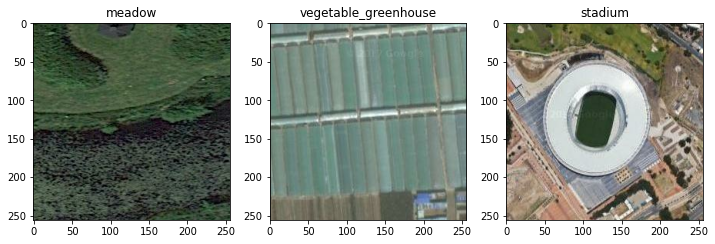

In [68]:
mapping_test(image_dataset)

## 2.3- Preprocessing Image Dataset

### 2.3.1- Applying "One-Hot Encoding"

1) Loading class names as a list by using "class_names.csv" file

In [15]:
classes_list = []
path_classes_list_file = path_root + "datasets/MLRSNet/class_names.csv"

with open(path_classes_list_file, "r", ) as my_file:
    new_content = csv.reader(my_file)
    for row in new_content:
        classes_list.append(row[0])

In [70]:
print(classes_list)
print("number of classes:", len(classes_list))

['airplane', 'airport', 'bareland', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland', 'farmland', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor&port', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway', 'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard', 'snowberg', 'sparse_residential_area', 'stadium', 'storage_tank', 'swimmimg_pool', 'tennis_court', 'terrace', 'transmission_tower', 'vegetable_greenhouse', 'wetland', 'wind_turbine']
number of classes: 46


1.1. [OPTIONAL] Getting class names as a list by using "get_list_of_classes" function

_Note: The list of classes that is used in training is given by the dataset maintainer. In custom datasets, we may need to get the classes from data itself. This is why it needs to be loaded by using "get_list_of_classes" function in some cases. Default training workflow of this script does not contain optional steps 1.1 and 1.2._

In [71]:
# def get_list_of_classes(dataset):

#     # Get unique class labels as a list by scanning the whole dataset 
#     classes_list = list({ element[1].numpy().decode("utf-8") for element in dataset})
    
#     # Return the classes list 
#     return classes_list

In [72]:
# classes_list = get_list_of_classes(image_dataset)
# classes_list = sorted(classes_list)
# print(classes_list)
# print("number of classes:", len(classes_list))

1.1. [OPTIONAL] Write classes list to CSV file

In [73]:
# with open("class_names.csv", "w", newline="") as sample_f:
#     sample_writer = csv.writer(sample_f, delimiter="\n", quoting=csv.QUOTE_ALL)
#     sample_writer.writerow(classes_list)

2) Defining one_hot_encoder function which takes "image" and "label" of each element and, outputs "image" "one hot encoded label"

In [22]:
def one_hot_encoder(image, label, classes):

    # Get the boolean match of the label
    tensor_classes_bool = tf.constant(classes) == label
    # Cast the boolean result as a tf.float32 tensor
    label_one_hot = tf.cast(tensor_classes_bool, dtype=tf.float32)

    # Return to replace
    return (image, label_one_hot)

3) Applying the transformation

In [75]:
image_dataset = image_dataset.map(lambda image,label: one_hot_encoder(image, label, classes_list))

In [76]:
print(image_dataset.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))


### 2.3.2- Resizing Image Dataset

1) Defining dataset element resizer function

In [23]:
def resize_image(image, label, size=[227,227]):

    # Resizing
    image = tf.image.resize(image, size)
    # Type casting to uint8 from float32
    image = tf.cast(image, dtype=tf.uint8) 
    # Normalization
    # image = tf.image.convert_image_dtype(image, tf.float32) 

    # Return image and label
    return image, label

2) Mapping the resizer function to the dataset

In [78]:
image_dataset = image_dataset.map(lambda image,label: resize_image(image,label, [227,227]))

In [79]:
print(image_dataset.element_spec)

(TensorSpec(shape=(227, 227, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))


3) Mapping test to the resized dataset

One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


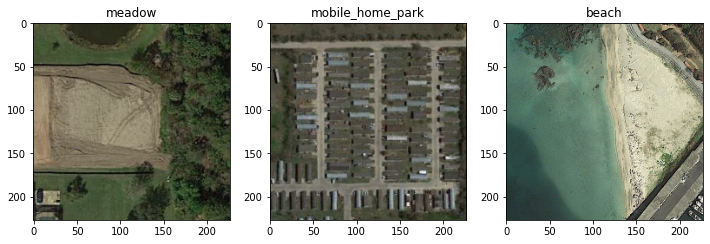

In [81]:
mapping_test(image_dataset, one_hot_label=True, classes=classes_list)

### 2.3.3- Scaling Image Dataset

1) Definign rescaler function that rescales each image element to between 0-1

In [24]:
def rescaler(image,label):

    # Apply scaling (normalization from statistic convension) to range between 0-1 
    image = tfl.Rescaling(scale=1./255) (image)

    # Return image and label
    return image,label

2) Apply the transformation

In [83]:
image_dataset = image_dataset.map(rescaler)

3) Test the mapping

tf.Tensor(
[[[0.29411766 0.30588236 0.3254902 ]
  [0.2627451  0.27450982 0.29411766]
  [0.18039216 0.19607845 0.20784315]
  ...
  [0.19215688 0.19215688 0.19215688]
  [0.11764707 0.11764707 0.11764707]
  [0.13725491 0.13725491 0.13725491]]

 [[0.16862746 0.18431373 0.20000002]
  [0.16470589 0.1764706  0.19607845]
  [0.13725491 0.15294118 0.16470589]
  ...
  [0.15294118 0.15294118 0.15294118]
  [0.1254902  0.1254902  0.1254902 ]
  [0.14901961 0.14901961 0.14901961]]

 [[0.14509805 0.16078432 0.17254902]
  [0.13333334 0.14901961 0.16078432]
  [0.1254902  0.14117648 0.15294118]
  ...
  [0.13725491 0.13725491 0.13725491]
  [0.13725491 0.13725491 0.13725491]
  [0.15294118 0.15294118 0.15294118]]

 ...

 [[0.37254903 0.39607847 0.3803922 ]
  [0.3137255  0.34117648 0.3254902 ]
  [0.5019608  0.5254902  0.50980395]
  ...
  [0.21176472 0.21568629 0.23137257]
  [0.18039216 0.18431373 0.20000002]
  [0.16078432 0.16470589 0.18039216]]

 [[0.16862746 0.18823531 0.17254902]
  [0.19215688 0.21176472 0

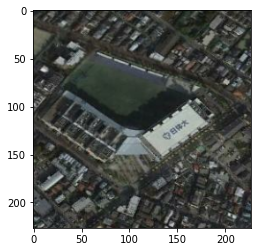

In [84]:
for image,label in image_dataset.take(1):
    print(image)
    print(label.numpy())
    img_ind = np.argmax(label.numpy())
    print(classes_list[img_ind])
    plt.imshow(image)

## 2.4- Configuring Image Dataset

1) Splitting training and test sets

In [85]:
def split_dataset(dataset, train_set_ratio, test_set_ratio, val_set_ratio=0):
    
    # Get the dataset length
    len_dataset = len(image_dataset)

    # Check if the ratio is correct
    if train_set_ratio + val_set_ratio + test_set_ratio != 1:
        raise ValueError("Incorrect split ratio")

    # Calculate the indices
    train_size = int(len_dataset * train_set_ratio)
    remaining_size = int(len_dataset - train_size)

    # If the val_set is intended
    if val_set_ratio != 0:
        val_set_ratio_remaining = float(val_set_ratio / (val_set_ratio + test_set_ratio))
        #print("val_set_ratio_remaining", val_set_ratio_remaining)
        val_size = int(remaining_size *  val_set_ratio_remaining)
        val_index = train_size + val_size
        test_size = remaining_size - val_size

    else:
        test_size = remaining_size

    # Write the sizes
    print("train size:",train_size)
    print("test size:", test_size)
    if val_set_ratio != 0: 
        print("val size:", val_size)

    # Split the dataset
    dataset_train = dataset.take(train_size)
    dataset_remaining = dataset.skip(train_size)

    if val_set_ratio != 0:
        dataset_val = dataset_remaining.take(val_size)
        dataset_test = dataset_remaining.skip(val_size)
         
        return dataset_train, dataset_test, dataset_val
        
    else:
        dataset_test = dataset_remaining
        return dataset_train, dataset_remaining


In [86]:
dataset_train, dataset_test, dataset_val = split_dataset(image_dataset, 0.8, 0.1, 0.10)

train size: 87328
test size: 10917
val size: 10916


2) Configuring mini batches

In [87]:
dataset_train = dataset_train.shuffle(buffer_size=5120, reshuffle_each_iteration=True).batch(128, drop_remainder=True)
dataset_val = dataset_val.shuffle(buffer_size=5120, reshuffle_each_iteration=True).batch(128, drop_remainder=True)
dataset_test = dataset_test.shuffle(buffer_size=5120, reshuffle_each_iteration=True).batch(128, drop_remainder=True)

# 3- Building Model

1) Defining the model architecture

In [32]:
def AlexNet(input_shape=(227,227,3), num_output_classes=10):

    """
    AlexNet implementation with the architecture from the original paper by Krizhevsky et al. (2012)
    
    inputs:
        input_shape - input shape for input image size from the original paper
        num_output_classes - output unit size for softmax classifier that decided by model purpose

    outputs:
        model - AlexNet model keras instance 
    """

    # input layer: tensor-like input object
    layer_input = tf.keras.Input(input_shape)

    # layer-1: 2D convolution
    layer1 = tfl.Conv2D(filters=96, kernel_size=11, strides=(4,4), activation="relu") (layer_input)
    layer1 = tfl.BatchNormalization() (layer1)
    layer1 = tfl.MaxPool2D(pool_size=(3,3), strides=(2,2)) (layer1)

    # layer-2: 2D convolution
    layer2 = tfl.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation="relu", padding="same", groups=2) (layer1) #, groups=2
    layer2 = tfl.BatchNormalization() (layer2)
    layer2 = tfl.MaxPool2D(pool_size=(3,3), strides=(2,2)) (layer2)

    # layer-3: 2D convolution
    layer3 = tfl.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer2)
    layer3 = tfl.BatchNormalization() (layer3)

    # layer-4: 2D convolution
    layer4 = tfl.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same", groups=2) (layer3) #, groups=2
    layer4 = tfl.BatchNormalization() (layer4)

    # layer-5: 2D convolution
    layer5 = tfl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same", groups=2) (layer4) #, groups=2
    layer5 = tfl.BatchNormalization() (layer5)
    layer5 = tfl.MaxPool2D(pool_size=(3,3), strides=(2,2)) (layer5)
    layer5 = tfl.Flatten() (layer5)

    # layer-6: fully-connected 
    layer6 = tfl.Dense(units=4096, activation="relu") (layer5) #lr decay
    layer6 = tfl.Dropout(rate=0.5) (layer6)

    # layer-7: fully-connected
    layer7 = tfl.Dense(units=4096, activation="relu") (layer6)  #lr decay
    layer7 = tfl.Dropout(rate=0.5) (layer7)

    # layer-8 (output layer): fully-connected
    layer_output = tfl.Dense(units=num_output_classes, activation="softmax") (layer7)

    # Defining Model object
    model = tf.keras.Model(inputs= layer_input,
                            outputs=layer_output,
                            )

    # Returning the model
    return model
    

2) Creating a CNN model

Defining input shape

In [33]:
input_shape = tuple([int(i) for i in image_dataset.element_spec[0].shape.__repr__()[-13:-2].split(", ")])
print(input_shape)

(227, 227, 3)


Defining output shape

In [34]:
output_classes_shape = len(classes_list)
print("Output shape:", output_classes_shape)

Output shape: 46


In [35]:
alexnetModel = AlexNet(input_shape, output_classes_shape)

3) Compiling the model

In [36]:
alexnetModel.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])

In [37]:
alexnetModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       307456    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024  

# 4- Training Model

1) Defining training callbacks

In [38]:
# Define the checkpoint path
path_checkpoint = path_root + "checkpoints/model_{epoch:02d}-{val_loss:.2f}"

# Define the ModelCheckpoint callback
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=False,
    monitor="val_accuracy",
    save_freq="epoch" )

# Define the EarlyStopping callback
callback_early_stopping  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

2) Fitting (training) the model

In [58]:
history = alexnetModel.fit(
    x=dataset_train,
    epochs=35,
    validation_data=dataset_val,
    callbacks=[
        callback_model_checkpoint,
        callback_early_stopping
        ],
    initial_epoch=30,
    )

Epoch 31/35
682/682 [==============================] - 877s 1s/step - loss: 0.1300 - accuracy: 0.9577 - val_loss: 0.2459 - val_accuracy: 0.9292
Epoch 32/35
682/682 [==============================] - 848s 1s/step - loss: 0.1240 - accuracy: 0.9597 - val_loss: 0.5644 - val_accuracy: 0.8657
Epoch 33/35
682/682 [==============================] - 698s 1s/step - loss: 0.1148 - accuracy: 0.9620 - val_loss: 0.2567 - val_accuracy: 0.9222
Epoch 34/35
682/682 [==============================] - 1269s 2s/step - loss: 0.1116 - accuracy: 0.9634 - val_loss: 0.1499 - val_accuracy: 0.9522
Epoch 35/35
682/682 [==============================] - 3453s 5s/step - loss: 0.1002 - accuracy: 0.9668 - val_loss: 0.0438 - val_accuracy: 0.9884


3. Plotting accuracy & loss graphs

In [60]:
history_loss = history.history["loss"]
history_accuracy = history.history["accuracy"]
history_val_loss = history.history["val_loss"]
history_val_accuracy = history.history["val_accuracy"]

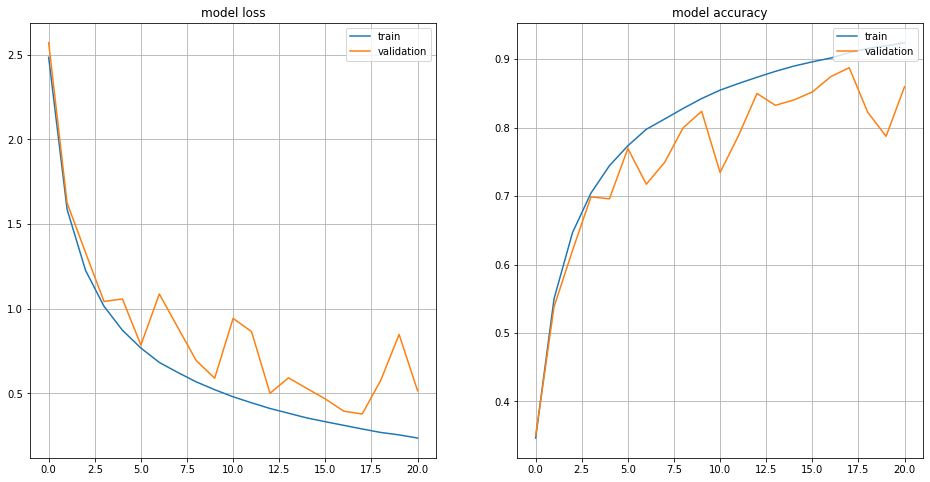

In [52]:
fig1, (ax11, ax12)  = plt.subplots(1, 2, figsize=(16,8))
ax11.plot(history_loss, label="train")
ax11.plot(history_val_loss, label="validation")
ax11.set_title("model loss")
ax11.legend(loc="upper right")
ax11.grid()

ax12.plot(history_accuracy, label="train")
ax12.plot(history_val_accuracy, label="validation")
ax12.set_title("model accuracy")
ax12.legend(loc="upper right")
ax12.grid()

# 5- Testing (Evaluating) the Model

In [62]:
test_history = alexnetModel.evaluate(dataset_test)

85/85 [==============================] - 65s 185ms/step - loss: 0.0465 - accuracy: 0.9864


In [63]:
print("Test loss:", test_history[0])
print("Test accuracy:", test_history[1])

Test loss: 0.04651716351509094
Test accuracy: 0.9863970875740051


# 6- Saving Model

In [65]:
model_name = "MLRSNet_AlexNet_35"

model_path = path_root + "models/" + model_name
print(model_path)

C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/models/MLSRNet_AlexNet_valacc_986


In [66]:
#alexnetModel.save(model_path)

INFO:tensorflow:Assets written to: C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/models/MLSRNet_AlexNet_valacc_986\assets


# 7- Reload Saved Model

In [3]:
model_name = "MLRSNet_AlexNet_35"

model_path = path_root + "models/" + model_name
print(model_path)

C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/models/MLRSNet_AlexNet_35


In [4]:
model_reloaded = tf.keras.models.load_model(model_path)

# 8- Make Predictions

## 8.1- User Image Prediction 

Load an user image to evaluate its content by using the trained model
1) Definition of untility functions

In [5]:
def load_user_image(path):

    # Lazy-load the image with PIL
    image_user = PIL.Image.open(path)
    plt.imshow(image_user)
    # Resize the image
    image_user = tf.image.resize(image_user, [227,227])
    # Rescale the image
    image_user = tfl.Rescaling(scale=1./255) (image_user)
    # Add batch axis
    image_user = image_user[tf.newaxis,:]
    print("User Image Shape:", image_user.shape)

    # Return the image
    return image_user

In [6]:
def print_pred_result(result, classes):
    print(f"{'Predictions':<30}Confidences")
    result_top5 = []
    result = list(result[0])

    zipped_results = list(zip(result, list(enumerate(classes))))
    sorted_zipped_results = sorted(zipped_results, reverse=True)
    sorted_results_top5 = sorted_zipped_results[:5]
    
    for i, result in enumerate(sorted_results_top5):

        result_index = result[1][0]
        predicted_class = result[1][1]
        confidence = result[0]
        print(f"{i+1} - {predicted_class:<25} - {confidence*100:.5f} %")
        result_top5.append([result_index, predicted_class, confidence])

    # return top-5 prediction list
    return result_top5

2) Define the user image path 

In [7]:
path_user_image = path_root + "user_images/industrial_area/industrial_area_2.png"

3) Load the user image and preprocess within the 'load_user_image' function

User Image Shape: (1, 227, 227, 3)


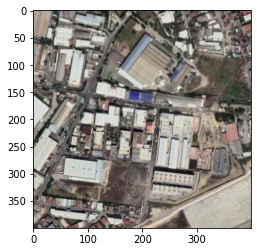

In [8]:
image_user = load_user_image(path_user_image)

4) Make prediction by using the trained model

In [9]:
result_user_image = model_reloaded.predict(image_user)

5) Print the top-5 prediction result

In [16]:
result_top5 = print_pred_result(result_user_image, classes_list)

Predictions                   Confidences
1 - industrial_area           - 90.36688 %
2 - dense_residential_area    - 5.16958 %
3 - storage_tank              - 2.80932 %
4 - commercial_area           - 1.24858 %
5 - park                      - 0.18379 %


## 8.2- User Set Prediction

1. Define the user image path

In [17]:
path_user_set = path_root + "user_images"
path_user_set

'C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/user_images'

2. Get the user dataset with filenames format

In [18]:
list_user_set = tf.data.Dataset.list_files(str(path_user_set+"/*/*"), shuffle=True)

# Examples
for ex in list_user_set.take(5):
    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\park\\park_2.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\forest\\forest_0.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\intersection\\intersection_0.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\roundabout\\roundabout_1.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\ground_track_field\\ground_track_field_4.png']


3) Apply "convert_path_to_image"

In [25]:
image_user_set = list_user_set.map(convert_path_to_image)

4) Apply "one_hot_encoder"

In [26]:
image_user_set = image_user_set.map(lambda image,label: one_hot_encoder(image, label, classes_list))

5) Apply "resize_image"

In [27]:
def resize_image(image, label, size=[227,227]):
    # Resizing
    image = tf.image.resize(image, size)
    # Type casting to uint8 from float32
    image = tf.cast(image, dtype=tf.uint8) 

    # Return image and label
    return image, label

In [28]:
image_user_set = image_user_set.map(resize_image)

6) Apply "rescaler"

In [29]:
image_user_set = image_user_set.map(rescaler)

Mapping Test

One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


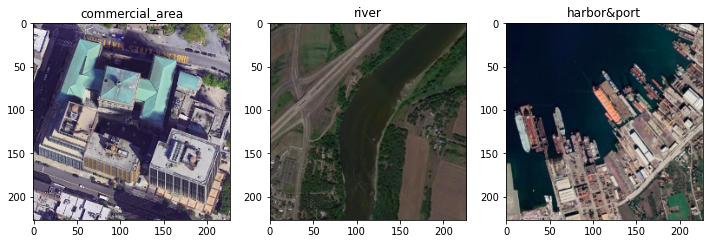

In [30]:
mapping_test(image_user_set, one_hot_label=True, classes=classes_list)

7. Apply mini-batching

In [31]:
image_user_set = image_user_set.batch(8)

In [32]:
image_user_set.element_spec

(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 46), dtype=tf.float32, name=None))

8) Predict user set

In [33]:
results_user_set = model_reloaded.evaluate(image_user_set)

20/20 [==============================] - 1s 27ms/step - loss: 3.2304 - accuracy: 0.4744


User Set Top-1 Score:

In [34]:
print("User set loss:", results_user_set[0])
print("User set accuracy:", results_user_set[1])

User set loss: 3.2303733825683594
User set accuracy: 0.4743589758872986
